# Tanmay Garg
## CS20BTECH11063
### Data Science Analysis Assignment 7

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
import astroML
from astroML.stats import sigmaG
import pandas as pd
import seaborn as sns
np.random.seed(0)
import emcee
import corner
from sklearn.neighbors import KernelDensity
from IPython.display import display, Math
import dynesty
import nestle

# Q1

$$f_{gas} = f_0(1+f_1z)$$



Optimization terminated successfully.
         Current function value: -200.732528
         Iterations: 60
         Function evaluations: 114


100%|██████████| 2000/2000 [03:45<00:00,  8.86it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

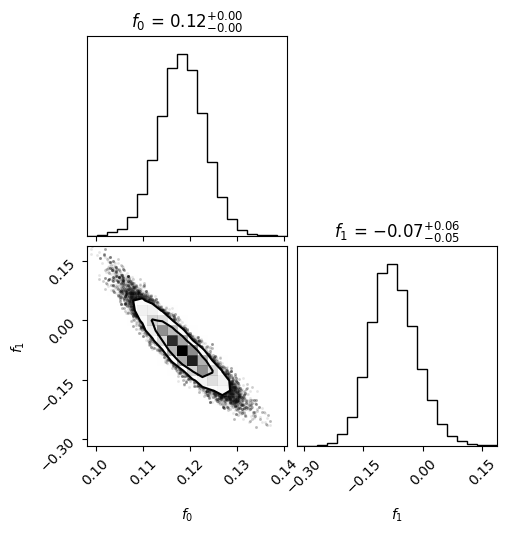

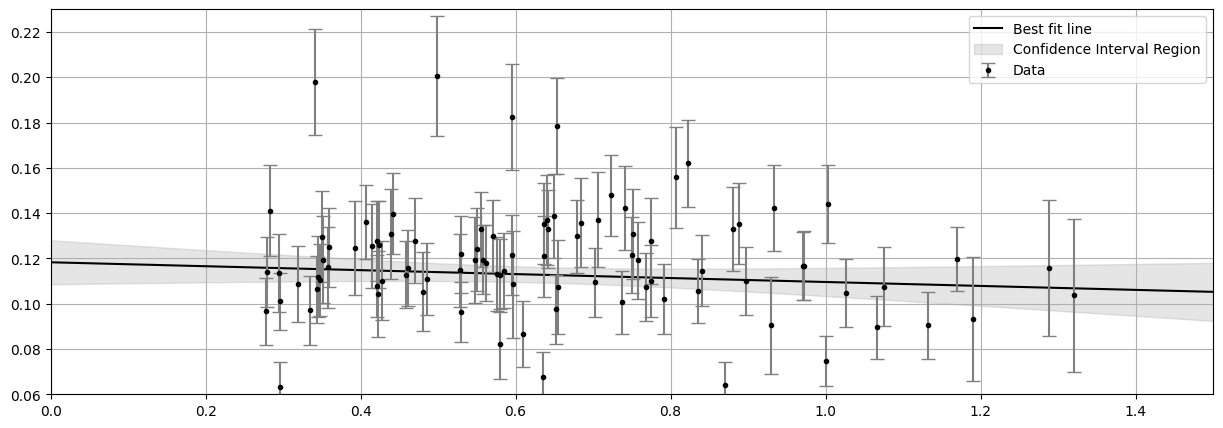

In [37]:
df = pd.read_csv('q1.txt', sep=' ')
z = df['z']
fgas = df['fgas']
fgas_error = df['fgas_error']

def log_prior(theta):
    f0, f1 = theta
    if 0 < f0 < 0.5 and -0.5 < f1 < 0.5:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, sigma_y):
    f0, f1 = theta
    model = f0 * (1 + f1 * x)
    chi2 = np.sum(np.log(2 * np.pi * sigma_y ** 2) + ((y - model) ** 2 / sigma_y ** 2))
    return -0.5 * chi2

def log_likelihood2(theta, x, y, sigma_y):
    f0, f1 = theta
    model = f0 * (1 + f1 * x)
    chi2 = np.sum(np.log(2 * np.pi * sigma_y ** 2) + ((y - model) ** 2 / sigma_y ** 2))
    return 0.5 * chi2

def log_probability(theta, x, y, sigma_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma_y)

# Solution from scipy.optimize.minimize
optimized_sol = optimize.fmin(log_likelihood2, [0.2, 0.0], args=(z, fgas, fgas_error))

# # plot the results
# f0, f1 = optimized_sol
# print(f0, f1)
# x = np.linspace(0, 1.5, 1000)
# y = f0 * (1 + f1 * x)
# plt.figure(figsize=(15, 5))
# plt.errorbar(z, fgas, yerr=fgas_error, fmt='.', color='black', capsize=5, ecolor='gray', label='Data')
# plt.plot(x, y, color='red')
# plt.xlabel('z')
# plt.ylabel('fgas')
# plt.ylim(0.06, 0.21)
# plt.xlim(0, 1.5)
# plt.grid()
# plt.show()

# Solution from emcee
ndim, nwalkers = 2, 64
# f0_random = np.random.uniform(0, 0.5, nwalkers)
# f1_random = np.random.uniform(-0.5, 0.5, nwalkers)
# pos = np.array([f0_random, f1_random]).T #optimized_sol.x + 1e-4 * np.random.randn(nwalkers, ndim)
pos = optimized_sol + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(z, fgas, fgas_error))

nburn = 1000
nsteps = 2000
sampler.run_mcmc(pos, nsteps, progress=True)
samples = sampler.get_chain(flat=True, discard=nburn)
# print(samples.shape)

f0_median, f1_median = np.median(samples, axis=0)
f0_68, f1_68 = np.percentile(samples, [16, 84], axis=0)
f0_90, f1_90 = np.percentile(samples, [5, 95], axis=0)

# print the results using math display
display(Math(r'f_0 = {0:.3f} +{1:.3f} -{2:.3f} (68\% CI)'.format(f0_median, f0_68[1] - f0_median, f0_median - f0_68[0])))
display(Math(r'f_1 = {0:.3f} +{1:.3f} -{2:.3f} (68\% CI)'.format(f1_median, f1_68[1] - f1_median, f1_median - f1_68[0])))
display(Math(r'f_0 = {0:.3f} +{1:.3f} -{2:.3f} (90\% CI)'.format(f0_median, f0_90[1] - f0_median, f0_median - f0_90[0])))
display(Math(r'f_1 = {0:.3f} +{1:.3f} -{2:.3f} (90\% CI)'.format(f1_median, f1_90[1] - f1_median, f1_median - f1_90[0])))
# print("f0 = {0:.3f} +{1:.3f} -{2:.3f} (68% CI)".format(f0_median, f0_68[1] - f0_median, f0_median - f0_68[0]))
# print("f1 = {0:.3f} +{1:.3f} -{2:.3f} (68% CI)".format(f1_median, f1_68[1] - f1_median, f1_median - f1_68[0]))
# print("f0 = {0:.3f} +{1:.3f} -{2:.3f} (90% CI)".format(f0_median, f0_90[1] - f0_median, f0_median - f0_90[0]))
# print("f1 = {0:.3f} +{1:.3f} -{2:.3f} (90% CI)".format(f1_median, f1_90[1] - f1_median, f1_median - f1_90[0]))


# Corner plot for 68% and 90% confidence intervals
# fig = plt.figure(figsize=(10, 10))
labels = [r"$f_0$", r"$f_1$"]
fig = corner.corner(samples, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

# plot the best fit line and the data 
samples_reshaped = samples.reshape((-1, ndim)).T
# print(samples_reshaped.shape)
x = np.linspace(0, 1.5, 1000)
f0, f1 = samples_reshaped[:2]
y = f0[:, None] * (1 + f1[:, None] * x)
# print(y.shape)
mu = np.mean(y, axis=0)
sig = 2 * y.std(0)
upper_bound = mu + sig
lower_bound = mu - sig

plt.figure(figsize=(15, 5))
plt.plot(x, mu, color='black', label='Best fit line')
plt.errorbar(z, fgas, yerr=fgas_error, fmt='.', color='black', capsize=5, ecolor='gray', label='Data')
plt.fill_between(x, lower_bound, upper_bound, color='grey', alpha=0.2, label='Confidence Interval Region')
plt.xlim(0, 1.5)
plt.ylim(0.06, 0.23)
plt.grid()
plt.legend()
plt.show()


Reference: http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/

# Q2

In [35]:
import numpy as np
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data

# def polynomial_fit(theta, x):
#     val = 0
#     for i in range(len(theta)):
#         val += theta[i] * x**i
#     return val

def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

def log_likelihood(theta, x=x, y=y, sigma_y=sigma_y):
    model = polynomial_fit(theta, x)
    # return -0.5 * (np.sum(np.log((y - model)**2 / sigma_y**2)) - np.sum(np.log(2 * np.pi * sigma_y**2)))
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2) + (y - model) ** 2 / sigma_y ** 2)

# def prior_transform(theta):
#     return theta

def prior_transform_linear(theta):
    # m = theta[0]*20 - 10
    # c = theta[1]*20 - 10
    m = theta[0]*10 - 5
    c = theta[1]*20 - 10
    return np.array([m, c])

def prior_transform_quadratic(theta):
    # a = theta[0]*20 - 10
    # b = theta[1]*20 - 10
    # c = theta[2]*20 - 20
    a = theta[0]*10 - 5
    b = theta[1]*10 - 5
    c = theta[2]*20 - 20

    return np.array([a, b, c])

nlive = 1024      
bound = 'multi'   
ndims = 2         
sample = 'unif'   
tol = 0.1         

sampler_linear = dynesty.NestedSampler(log_likelihood, prior_transform_linear, ndims, nlive=nlive, bound=bound, sample=sample)
samples_linear = sampler_linear.run_nested(dlogz=tol, print_progress=True)
results_linear = sampler_linear.results
log_z_linear = results_linear.logz[-1]
print(results_linear.summary())

nlive = 1024      
bound = 'multi'   
ndims = 3         
sample = 'unif'   
tol = 0.1         

sampler_quadratic = dynesty.NestedSampler(log_likelihood, prior_transform_quadratic, ndims, nlive=nlive, bound=bound, sample=sample)
samples_quadratic = sampler_quadratic.run_nested(dlogz=tol, print_progress=True)
results_quadratic = sampler_quadratic.results
log_z_quadratic = results_quadratic.logz[-1]
print(results_quadratic.summary())


print("Bayes Factor Quad/Linear: ", np.exp(log_z_quadratic - log_z_linear))
print("Bayes Factor Linear/Quad: ", np.exp(log_z_linear - log_z_quadratic))

12301it [00:26, 472.31it/s, +1024 | bound: 10 | nc: 1 | ncall: 52218 | eff(%): 26.028 | loglstar:   -inf < 22.011 <    inf | logz: 12.353 +/-  0.092 | dlogz:  0.000 >  0.100]


Summary
nlive: 1024
niter: 12301
ncall: 51194
eff(%): 26.028
logz: 12.353 +/-  0.117
None


14808it [00:30, 486.20it/s, +1024 | bound: 16 | nc: 1 | ncall: 61741 | eff(%): 26.075 | loglstar:   -inf < 22.938 <    inf | logz: 10.824 +/-  0.103 | dlogz:  0.000 >  0.100]

Summary
nlive: 1024
niter: 14808
ncall: 60717
eff(%): 26.075
logz: 10.824 +/-  0.130
None
Bayes Factor Quad/Linear:  0.21693406932453035
Bayes Factor Linear/Quad:  4.609695485424256


According to the above sampling using ```dynesty``` package, we can see that linear model is being favoured more than the quadratic model, and this does not match with the value given in the blog

Reference:

http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/

# Q3

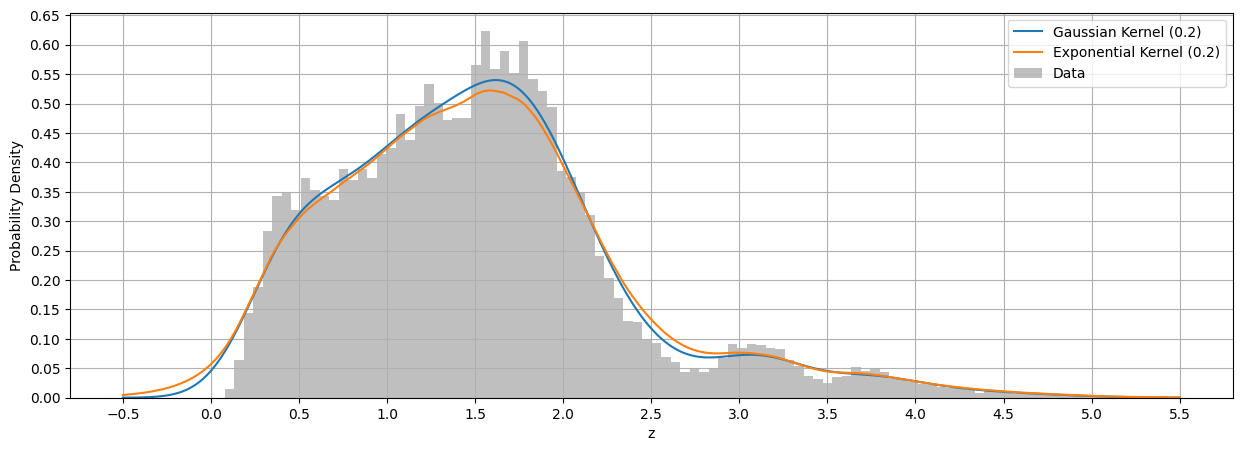

In [36]:
df = pd.read_csv('q3.csv', sep='\t')
z = df['z']
# Plot KDE estimate for z using gaussian and exponential kernels (with bandwidth=0.2)

plt.figure(figsize=(15, 5))
plt.xticks(np.arange(-1, 6, 0.5))
plt.yticks(np.arange(0, 1.1, 0.05))

x = np.linspace(-0.5, 5.5, 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z.to_numpy().reshape(-1, 1))
log_dens = kde.score_samples(x.reshape(-1,1))

plt.plot(x, np.exp(log_dens), label='Gaussian Kernel (0.2)')
kde = KernelDensity(kernel='exponential', bandwidth=0.2).fit(z.to_numpy().reshape(-1, 1))
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens), label='Exponential Kernel (0.2)')
plt.hist(z, bins='auto', density=True, color='grey', alpha=0.5, label='Data')
plt.xlabel('z')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

